# **Faces and Emotions**

### Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from keras.preprocessing.image import image

from keras.layers import  BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd

from tensorflow.keras.preprocessing import image
import numpy as np


### Importing and Preparing the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/My Drive/Dataset"

fer.csv


In [4]:
file_path = "/content/drive/My Drive/Dataset/fer.csv"
df_face = pd.read_csv(file_path)

In [5]:
df_face.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df_face.shape

(35887, 3)

In [7]:
## Splitting the dataset to get individual pixels
df_face['pixel'] = df_face.apply(lambda row: row.pixels.split(" "), axis = 1)

In [8]:
df_face.head()

,emotion,pixels,Usage,pixel
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
## Droping Pixels column since it's not required
df_face.drop(columns = "pixels", axis = 1, inplace = True)
df_face.rename(columns = {"pixel": "pixels"}, inplace = True)
df_face.head()

,emotion,Usage,pixels
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [10]:
## Creating copy of dataframs to view image using below function
df = df_face.copy()

In [11]:
## Function to view image using pixel values
def view_image(data, row_id):
  emotion = {0 : "Angry", 1 : "Disgust", 2 : "Fear", 3 : "Happy", 4 : "Sad", 5 : "Surprise", 6 : "Neutral"}
  num_emotion = data['emotion'][row_id]
  print(num_emotion, emotion[num_emotion])
  img = np.array(np.float32(data['pixels'][row_id]).reshape(48,48,1))
  pil_img = tf.keras.preprocessing.image.array_to_img(img)
  imgplot = plt.imshow(pil_img)
  plt.show()

3 Happy


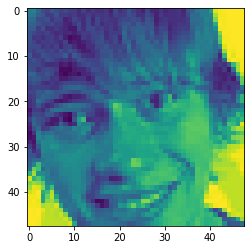

In [12]:
view_image(df,7997)

In [13]:
## Converting it into Float 32

df_face['pixels'] = df_face.apply(lambda row: np.array(np.float32(row.pixels)), axis=1)

In [14]:
## Normalising the data

df_face['pixels'] = df_face.apply(lambda row: np.array(row.pixels) / 255, axis=1)

In [15]:
df_face.head()

,emotion,Usage,pixels
0,0,Training,"[0.27450982, 0.3137255, 0.32156864, 0.28235295..."
1,0,Training,"[0.5921569, 0.5882353, 0.5764706, 0.60784316, ..."
2,2,Training,"[0.90588236, 0.83137256, 0.6117647, 0.6431373,..."
3,4,Training,"[0.09411765, 0.1254902, 0.14117648, 0.11764706..."
4,6,Training,"[0.015686275, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."


In [16]:
df_face.shape

(35887, 3)

In [17]:
## Checking count of fields for test train split
cnt = df_face.groupby("Usage").count()
print(cnt)

             emotion  pixels
Usage                       
PrivateTest     3589    3589
PublicTest      3589    3589
Training       28709   28709


In [18]:
## Checking count of fields for test train split
cnt = df_face.groupby(["Usage","emotion"]).count()
print(cnt)

                     pixels
Usage       emotion        
PrivateTest 0           491
            1            55
            2           528
            3           879
            4           594
            5           416
            6           626
PublicTest  0           467
            1            56
            2           496
            3           895
            4           653
            5           415
            6           607
Training    0          3995
            1           436
            2          4097
            3          7215
            4          4830
            5          3171
            6          4965


Dividing the data fro Train, Test and Validation as below:

Train = Training (80%)

Test = PublicTest (10%)

Validation = PrivateTest (10%)

From Training stats :
 
0 --> 3995

1 --> 436

2 --> 4097

3 --> 7215

4 --> 4830

5 --> 3171

6 --> 4965

The data set for trainging has higher samples of Happy faces and very less sample of Disgust sample. So the classes are impalanced for tranining. 

In [19]:
# Training Set
X_train = np.array(df_face[df_face["Usage"] == "Training"]["pixels"].to_list())
Y_train = df_face[df_face["Usage"] == "Training"]["emotion"]

#Validation Set
X_val = np.array(df_face[df_face["Usage"] == "PrivateTest"]["pixels"].to_list())
Y_val = df_face[df_face["Usage"] == "PrivateTest"]["emotion"]

#Test Set
X_test = np.array(df_face[df_face["Usage"] == "PublicTest"]["pixels"].to_list())
Y_test = df_face[df_face["Usage"] == "PublicTest"]["emotion"]

In [20]:
## reshaping the data sets
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [21]:
type(X_train)

numpy.ndarray

In [22]:
## Converting Target column into Categorical Dataset

Y_train = tf.keras.utils.to_categorical(Y_train, 7) 
Y_test = tf.keras.utils.to_categorical(Y_test, 7)
Y_val = tf.keras.utils.to_categorical(Y_val, 7)

type(Y_train)

numpy.ndarray

In [23]:
Y_train.shape

(28709, 7)

In [24]:
Y_train[0]

array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
## Converitng data into dataframe for model to accept the data
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
Y_val = pd.DataFrame(Y_val)

In [26]:
## Checking Shape of sample:
img_width = 48
img_height = 48
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    input_shape=(1, img_width, img_height)
else:
    input_shape=(img_width,img_height,1)

### Creating the Model

In [27]:
## Function to get Model Stats

def model_stats(training_model):
  print(training_model.history.keys())
  # summarize training for accuracy
  plt.plot(training_model.history['accuracy'])
  plt.plot(training_model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize traning for loss
  plt.plot(training_model.history['loss'])
  plt.plot(training_model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

#### Model_1

In [28]:
model_1 = Sequential()

#Layer 1
model_1.add(Conv2D(64,(5,5),input_shape=input_shape)) 
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
#model_1.add(Dropout(0.25))

#Layer 2
model_1.add(Conv2D(128,(5,5))) 
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
#model_1.add(Dropout(0.25))


#Layer 3
model_1.add(Conv2D(256,(3,3))) 
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Activation('relu'))
#model_1.add(Dropout(0.25))

#Layer 4
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.25))
model_1.add(Dense(7, activation='softmax')) 


model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 18, 18, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 128)         0

In [29]:
model_1.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
[print(i.shape, i.dtype) for i in model_1.inputs]
[print(o.shape, o.dtype) for o in model_1.outputs]
#[print(l.name, l.input_shape, l.dtype) for l in model_1.layers]

(None, 48, 48, 1) <dtype: 'float32'>
(None, 7) <dtype: 'float32'>


[None]

In [31]:
## Traning basic model
train_1 = model_1.fit( X_train,Y_train, batch_size = 40, epochs = 20, validation_data=(X_val, Y_val))

Epoch 1/20
718/718 [==============================] - 21s 7ms/step - loss: 1.6207 - accuracy: 0.3847 - val_loss: 1.6446 - val_accuracy: 0.3605
Epoch 2/20
718/718 [==============================] - 5s 6ms/step - loss: 1.3096 - accuracy: 0.5045 - val_loss: 1.6588 - val_accuracy: 0.3658
Epoch 3/20
718/718 [==============================] - 5s 6ms/step - loss: 1.2050 - accuracy: 0.5451 - val_loss: 1.3560 - val_accuracy: 0.5043
Epoch 4/20
718/718 [==============================] - 5s 6ms/step - loss: 1.1226 - accuracy: 0.5819 - val_loss: 1.5569 - val_accuracy: 0.4135
Epoch 5/20
718/718 [==============================] - 5s 6ms/step - loss: 1.0302 - accuracy: 0.6179 - val_loss: 1.2246 - val_accuracy: 0.5378
Epoch 6/20
718/718 [==============================] - 5s 6ms/step - loss: 0.9323 - accuracy: 0.6545 - val_loss: 1.4828 - val_accuracy: 0.4413
Epoch 7/20
718/718 [==============================] - 5s 6ms/step - loss: 0.8190 - accuracy: 0.7029 - val_loss: 1.4272 - val_accuracy: 0.4868
Epoch

In [32]:
model_1.evaluate(X_test,Y_test, verbose=2)

113/113 - 0s - loss: 2.2766 - accuracy: 0.5302


[2.276566982269287, 0.530231237411499]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


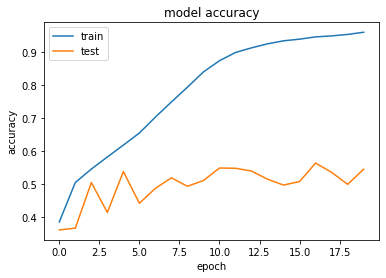

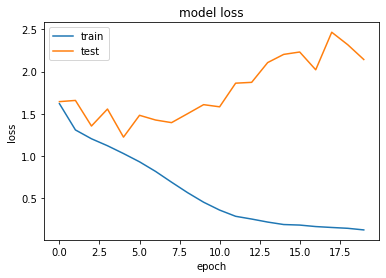

In [33]:
## Gathering model stats
model_stats(train_1)

#### Model_2

In [34]:
model_2 = Sequential()

#Layer 1
model_2.add(Conv2D(64,(5,5),input_shape=input_shape)) 
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))

#Layer 2
model_2.add(Conv2D(128,(5,5))) 
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))


#Layer 3
model_2.add(Conv2D(256,(3,3))) 
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.25))

#Layer 4
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.25))
model_2.add(Dense(7, activation='softmax')) 


model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
activation_3 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 18, 18, 128)      

In [35]:
model_2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
## Traning model with dropout layers
train_2 = model_2.fit( X_train,Y_train, batch_size = 120, epochs = 30, validation_data=(X_val, Y_val))

Epoch 1/30
240/240 [==============================] - 5s 13ms/step - loss: 1.8039 - accuracy: 0.3274 - val_loss: 1.9177 - val_accuracy: 0.1744
Epoch 2/30
240/240 [==============================] - 3s 12ms/step - loss: 1.4771 - accuracy: 0.4367 - val_loss: 1.5929 - val_accuracy: 0.3402
Epoch 3/30
240/240 [==============================] - 3s 12ms/step - loss: 1.3543 - accuracy: 0.4846 - val_loss: 1.5143 - val_accuracy: 0.4001
Epoch 4/30
240/240 [==============================] - 3s 12ms/step - loss: 1.2830 - accuracy: 0.5109 - val_loss: 1.4944 - val_accuracy: 0.4291
Epoch 5/30
240/240 [==============================] - 3s 12ms/step - loss: 1.2357 - accuracy: 0.5341 - val_loss: 1.3457 - val_accuracy: 0.5018
Epoch 6/30
240/240 [==============================] - 3s 12ms/step - loss: 1.1959 - accuracy: 0.5477 - val_loss: 1.2641 - val_accuracy: 0.5183
Epoch 7/30
240/240 [==============================] - 3s 12ms/step - loss: 1.1599 - accuracy: 0.5623 - val_loss: 1.4952 - val_accuracy: 0.4380

In [37]:
model_2.evaluate(X_test,Y_test, verbose=2)

113/113 - 0s - loss: 1.5013 - accuracy: 0.5085


[1.5012869834899902, 0.5084981918334961]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


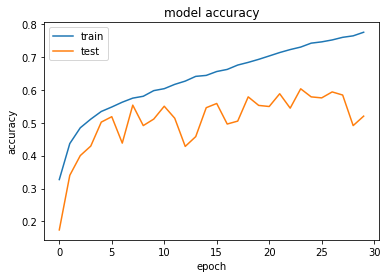

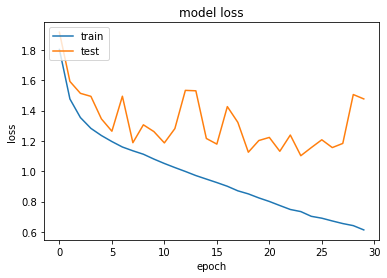

In [38]:
## Gathering model stats
model_stats(train_2)

#### Model_3

In [39]:
## Adding Learning Rate and early stopping using callback function

from keras.layers import  BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [40]:
model_3 = Sequential()

#Layer 1
model_3.add(Conv2D(64,(5,5),input_shape=input_shape)) 
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))

#Layer 2
model_3.add(Conv2D(128,(5,5))) 
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))


#Layer 3
model_3.add(Conv2D(256,(3,3))) 
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.25))

#Layer 4
model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))
model_3.add(Dense(7, activation='softmax')) 


model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 18, 18, 128)      

In [41]:
model_3.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
## Traning model with callbacks
train_3 = model_3.fit( X_train,Y_train, batch_size = 120, epochs = 50, validation_data=(X_val, Y_val), callbacks= callbacks)

Epoch 1/50
240/240 [==============================] - 4s 13ms/step - loss: 1.8269 - accuracy: 0.3196 - val_loss: 1.9001 - val_accuracy: 0.1775
Epoch 2/50
240/240 [==============================] - 3s 12ms/step - loss: 1.5012 - accuracy: 0.4263 - val_loss: 1.5985 - val_accuracy: 0.3734
Epoch 3/50
240/240 [==============================] - 3s 12ms/step - loss: 1.3671 - accuracy: 0.4823 - val_loss: 1.4578 - val_accuracy: 0.4400
Epoch 4/50
240/240 [==============================] - 3s 12ms/step - loss: 1.2926 - accuracy: 0.5108 - val_loss: 1.3280 - val_accuracy: 0.5007
Epoch 5/50
240/240 [==============================] - 3s 12ms/step - loss: 1.2421 - accuracy: 0.5274 - val_loss: 1.4927 - val_accuracy: 0.4355
Epoch 6/50
240/240 [==============================] - 3s 12ms/step - loss: 1.2034 - accuracy: 0.5456 - val_loss: 1.4192 - val_accuracy: 0.4684

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
240/240 [==============================] - 3s 12ms

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


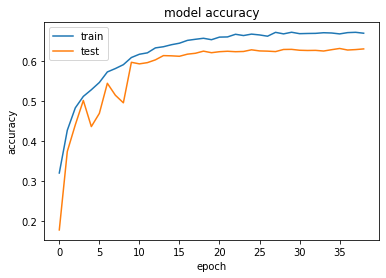

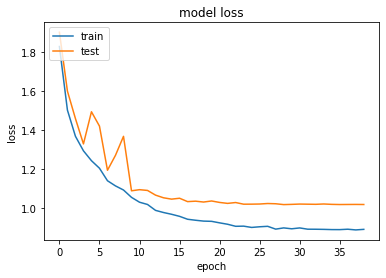

In [43]:
## Gathering model stats

model_stats(train_3)

In [44]:
print(train_3.history)
# Generate generalization metrics
#score = train_3.evaluate(X_test, Y_test, verbose=2)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

{'loss': [1.826892614364624, 1.5011860132217407, 1.3670639991760254, 1.292603850364685, 1.2420611381530762, 1.203401803970337, 1.1393052339553833, 1.112868309020996, 1.0918179750442505, 1.0542136430740356, 1.0292937755584717, 1.0177452564239502, 0.987515389919281, 0.9765115976333618, 0.967510998249054, 0.9569345116615295, 0.942009687423706, 0.9369277358055115, 0.932525098323822, 0.9313385486602783, 0.9235551357269287, 0.9163795709609985, 0.9059315919876099, 0.9066778421401978, 0.9001237750053406, 0.9034735560417175, 0.9058577418327332, 0.8914119005203247, 0.8977168798446655, 0.8931304216384888, 0.8975598812103271, 0.8910487294197083, 0.8908170461654663, 0.8902043700218201, 0.8890482187271118, 0.8888978362083435, 0.8909545540809631, 0.887382447719574, 0.8902410268783569], 'accuracy': [0.3195861876010895, 0.4262774884700775, 0.48225295543670654, 0.510815441608429, 0.5274304151535034, 0.5455780625343323, 0.5719112753868103, 0.5803754925727844, 0.5900936722755432, 0.6079277992248535, 0.616

In [45]:
model_3.evaluate(X_test,Y_test, verbose=2)

113/113 - 0s - loss: 1.0687 - accuracy: 0.6010


[1.068679928779602, 0.6010030508041382]

#### Model_4

In [46]:
## Adding Learning Rate and early stopping using callback function

from keras.layers import  BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, ## increasing the patience
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [47]:
## Increasing the value of dropout layer
model_4 = Sequential()

#Layer 1
model_4.add(Conv2D(64,(5,5),input_shape=input_shape)) 
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.4))

#Layer 2
model_4.add(Conv2D(128,(5,5))) 
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.4))


#Layer 3
model_4.add(Conv2D(256,(3,3))) 
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.4))

#Layer 4
model_4.add(Flatten())
model_4.add(Dense(128, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.4))
model_4.add(Dense(7, activation='softmax')) 


model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 18, 18, 128)      

In [48]:
model_4.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
## Traning model with callbacks
train_4 = model_4.fit( X_train,Y_train, batch_size = 120, epochs = 50, validation_data=(X_val, Y_val), callbacks= callbacks)

Epoch 1/50
240/240 [==============================] - 4s 13ms/step - loss: 1.9823 - accuracy: 0.2749 - val_loss: 1.9406 - val_accuracy: 0.2455
Epoch 2/50
240/240 [==============================] - 3s 12ms/step - loss: 1.6061 - accuracy: 0.3846 - val_loss: 1.7142 - val_accuracy: 0.3034
Epoch 3/50
240/240 [==============================] - 3s 12ms/step - loss: 1.4838 - accuracy: 0.4282 - val_loss: 1.4619 - val_accuracy: 0.4444
Epoch 4/50
240/240 [==============================] - 3s 12ms/step - loss: 1.4087 - accuracy: 0.4639 - val_loss: 1.4946 - val_accuracy: 0.4121
Epoch 5/50
240/240 [==============================] - 3s 12ms/step - loss: 1.3593 - accuracy: 0.4809 - val_loss: 1.3282 - val_accuracy: 0.4901
Epoch 6/50
240/240 [==============================] - 3s 12ms/step - loss: 1.3242 - accuracy: 0.4967 - val_loss: 1.4143 - val_accuracy: 0.4232
Epoch 7/50
240/240 [==============================] - 3s 12ms/step - loss: 1.2961 - accuracy: 0.5079 - val_loss: 1.2519 - val_accuracy: 0.5202

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


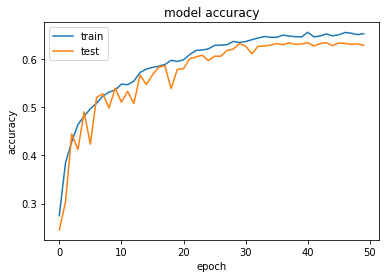

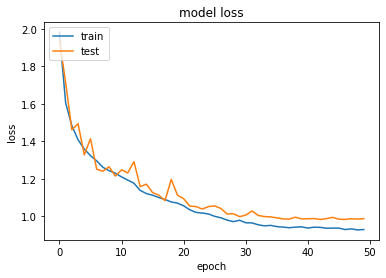

In [50]:
## Gathering model stats

model_stats(train_4)

In [51]:
print(train_4.history)
# Generate generalization metrics
#score = train_3.evaluate(X_test, Y_test, verbose=2)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

{'loss': [1.9823213815689087, 1.6060872077941895, 1.4837570190429688, 1.4086774587631226, 1.359299659729004, 1.3242137432098389, 1.2960890531539917, 1.2620303630828857, 1.2436249256134033, 1.2306275367736816, 1.2106186151504517, 1.1939741373062134, 1.1767480373382568, 1.1390445232391357, 1.1217458248138428, 1.1129534244537354, 1.1006104946136475, 1.0901739597320557, 1.0771420001983643, 1.070983648300171, 1.0565986633300781, 1.0350241661071777, 1.0213971138000488, 1.0177578926086426, 1.0130268335342407, 1.0004494190216064, 0.9925719499588013, 0.980226993560791, 0.9721981287002563, 0.9794299006462097, 0.9660540819168091, 0.965387761592865, 0.9553511142730713, 0.9496517777442932, 0.9521544575691223, 0.9455365538597107, 0.9429386258125305, 0.9396011233329773, 0.9427633285522461, 0.9444910287857056, 0.9377685785293579, 0.9425249695777893, 0.9414798617362976, 0.9367511868476868, 0.9377236366271973, 0.9375606775283813, 0.9299391508102417, 0.9334774613380432, 0.9279475808143616, 0.930019438266

In [52]:
model_4.evaluate(X_test,Y_test, verbose=2)

113/113 - 0s - loss: 1.0249 - accuracy: 0.6174


[1.024917483329773, 0.6174421906471252]

#### Model_5

In [53]:
## Adding Learning Rate and early stopping using callback function

from keras.layers import  BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, ## increasing the patience
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [54]:

model_5 = Sequential()

#Layer 1
model_5.add(Conv2D(64,(5,5),input_shape=input_shape)) 
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Activation('relu'))
model_5.add(Dropout(0.3))

#Layer 2
model_5.add(Conv2D(128,(5,5))) 
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Activation('relu'))
model_5.add(Dropout(0.3))


#Layer 3
model_5.add(Conv2D(256,(3,3))) 
model_5.add(BatchNormalization())
model_5.add(MaxPooling2D(pool_size=(2,2)))
model_5.add(Activation('relu'))
model_5.add(Dropout(0.3))

#Layer 4
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(BatchNormalization())
model_5.add(Dropout(0.25))
model_5.add(Dense(7, activation='softmax')) 


model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
activation_12 (Activation)   (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 18, 18, 128)      

In [55]:
model_5.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
## Traning model with callbacks
train_5 = model_5.fit( X_train,Y_train, batch_size = 120, epochs = 50, validation_data=(X_val, Y_val), callbacks= callbacks)

Epoch 1/50
240/240 [==============================] - 4s 13ms/step - loss: 1.7970 - accuracy: 0.3368 - val_loss: 1.9597 - val_accuracy: 0.2502
Epoch 2/50
240/240 [==============================] - 3s 13ms/step - loss: 1.4668 - accuracy: 0.4460 - val_loss: 1.7643 - val_accuracy: 0.3174
Epoch 3/50
240/240 [==============================] - 3s 13ms/step - loss: 1.3458 - accuracy: 0.4898 - val_loss: 1.4238 - val_accuracy: 0.4296
Epoch 4/50
240/240 [==============================] - 3s 13ms/step - loss: 1.2787 - accuracy: 0.5138 - val_loss: 1.4594 - val_accuracy: 0.4079
Epoch 5/50
240/240 [==============================] - 3s 13ms/step - loss: 1.2339 - accuracy: 0.5296 - val_loss: 1.6042 - val_accuracy: 0.3344
Epoch 6/50
240/240 [==============================] - 3s 13ms/step - loss: 1.1983 - accuracy: 0.5462 - val_loss: 1.3588 - val_accuracy: 0.4935
Epoch 7/50
240/240 [==============================] - 3s 13ms/step - loss: 1.1681 - accuracy: 0.5600 - val_loss: 1.4431 - val_accuracy: 0.4221

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


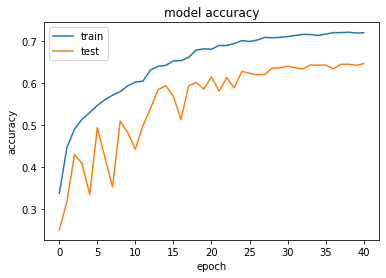

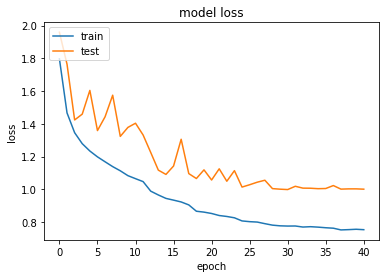

In [57]:
## Gathering model stats

model_stats(train_5)

In [58]:
print(train_5.history)
# Generate generalization metrics
#score = train_3.evaluate(X_test, Y_test, verbose=2)
#print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

{'loss': [1.797027349472046, 1.4667586088180542, 1.3458319902420044, 1.2787013053894043, 1.2339415550231934, 1.1982531547546387, 1.168144941329956, 1.1386357545852661, 1.1130406856536865, 1.0833951234817505, 1.0649654865264893, 1.046927809715271, 0.9886670112609863, 0.9653760194778442, 0.9444183707237244, 0.9338008165359497, 0.9226469397544861, 0.9046957492828369, 0.8659701347351074, 0.8605109453201294, 0.8522059321403503, 0.8397637009620667, 0.8339751362800598, 0.8258556127548218, 0.8067203760147095, 0.8022400736808777, 0.7997646927833557, 0.789982795715332, 0.780964195728302, 0.7767871022224426, 0.7753549218177795, 0.7757443785667419, 0.7693511247634888, 0.7715111374855042, 0.7687646150588989, 0.7650877237319946, 0.7622829079627991, 0.7517995238304138, 0.7535387277603149, 0.7557884454727173, 0.7532098293304443], 'accuracy': [0.33679333329200745, 0.4459925591945648, 0.4898463785648346, 0.5138109922409058, 0.5295552015304565, 0.546170175075531, 0.559998631477356, 0.5705876350402832, 0.

In [59]:
model_5.evaluate(X_test,Y_test, verbose=2)

113/113 - 0s - loss: 1.0387 - accuracy: 0.6264


[1.0386568307876587, 0.6263583302497864]

### Model Stats

 For MODEL 1
113/113 - 0s - loss: 2.2766 - accuracy: 0.5302
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


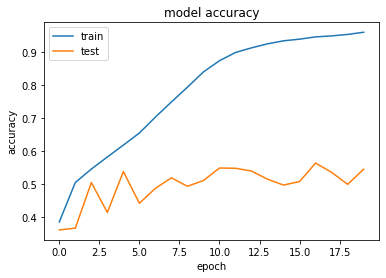

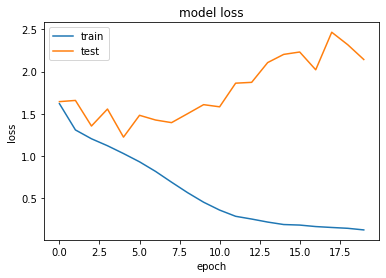

-----------------------------------------------------------------------------
 For MODEL 2
113/113 - 0s - loss: 1.5013 - accuracy: 0.5085
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


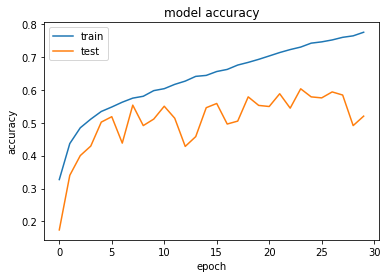

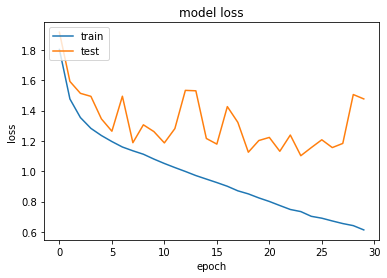

-----------------------------------------------------------------------------
 For MODEL 3
113/113 - 0s - loss: 1.0687 - accuracy: 0.6010
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


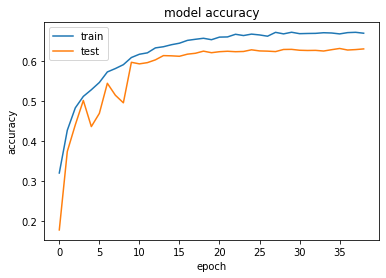

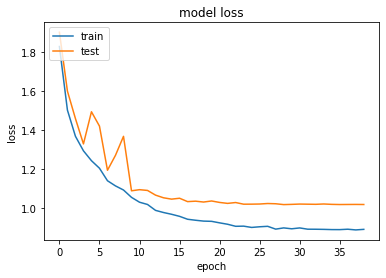

-----------------------------------------------------------------------------
 For MODEL 4
113/113 - 0s - loss: 1.0249 - accuracy: 0.6174
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


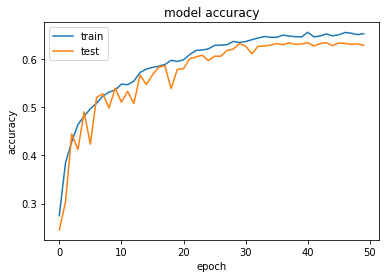

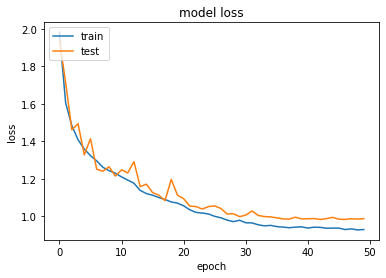

-----------------------------------------------------------------------------
 For MODEL 5
113/113 - 0s - loss: 1.0387 - accuracy: 0.6264
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


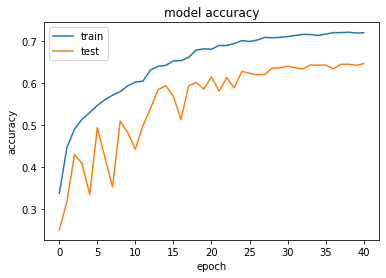

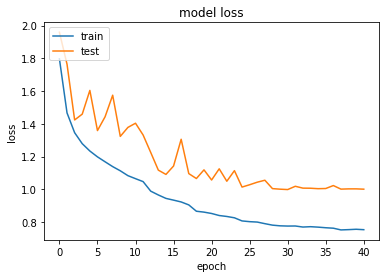

-----------------------------------------------------------------------------


In [60]:
for i in range(1,6):
  print(" For MODEL " + str(i))
  mod = "model_"+str(i)+".evaluate(X_test,Y_test, verbose=2)"
  stat = "model_stats(train_"+str(i)+")"

  exec(mod)
  exec(stat)

  print("-----------------------------------------------------------------------------")
  

Model 4 is the best model out of all. Although the data was skewed with more data to train for Happy faces the model performed well with minimum loss to validation loss and good accuracy out of all.

The model parameters are as below and it's trained with learning rate of 0.00001 and patience = 3



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
activation_9 (Activation)    (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 128)       204928    
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 18, 18, 128)       512       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 128)         0         
_________________________________________________________________
activation_10 (Activation)   (None, 9, 9, 128)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 7, 7, 256)         1024      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
activation_11 (Activation)   (None, 3, 3, 256)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 3, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               295040    
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 128)               512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 903       

Total params: 800,007

Trainable params: 798,855

Non-trainable params: 1,152
_________________________________________________________________